# Data
The dataset is from https://zenodo.org/record/1000885
It contains reviews of games on the Steam platform, and whether the reviewer recommends it nor not.
Columns used in this job is:
- app_name: Name of the reviewed game.
- app_id: ID of the reviewed game.
- review_text: The written review.
- review_score: Value 1 if the reviewer recommends it, -1 if not.

# Part 1: Data loading
1. The data will be loaded into a pandas dataframe.
2. The game Team Fortress 2 will be picked for this job.
3. The datafram will be balanced with 50% recommendations and 50% non-recommendations.
4. The mean lengths of the reviews will be checked per review_score, and the length distribution plotted.
The conclusion is that positive reviews are generally shorter than negative reviews.

In [176]:
import pandas as pd
import numpy as np
import math

In [177]:
# Read csv, pick Team Fortress 2 as the game to analyze and keep relevant columns.

df_full = pd.read_csv('data\\steam_reviews.csv', index_col=0)

df = df_full[df_full['app_name'] == 'Team Fortress 2']
df = df.drop('review_votes', axis=1)

df.head()

,app_name,review_text,review_score
app_id,,,
440,Team Fortress 2,My hours. help. I wrote something for real! ...,1
440,Team Fortress 2,This is the cycle of every Team Fortress 2...,1
440,Team Fortress 2,It's good.,1
440,Team Fortress 2,"If you bind forward to a button on your mouse,...",1
440,Team Fortress 2,The vicious cycle of Team fortress 2 First wh...,1


In [178]:
# Check number of reviews per score.

df.groupby(['app_name', 'review_score']).size()

app_name         review_score
Team Fortress 2  -1               1483
                  1              10737
dtype: int64

In [179]:
# Balance the df based on review_score to make the future models evaluation metrics clearer.

g = df.groupby('review_score')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True))
df.groupby(['app_name', 'review_score']).size()

app_name         review_score
Team Fortress 2  -1              1483
                  1              1483
dtype: int64

Review mean length:
review_score
-1    558.960890
 1    266.891436
Name: review_length, dtype: float64


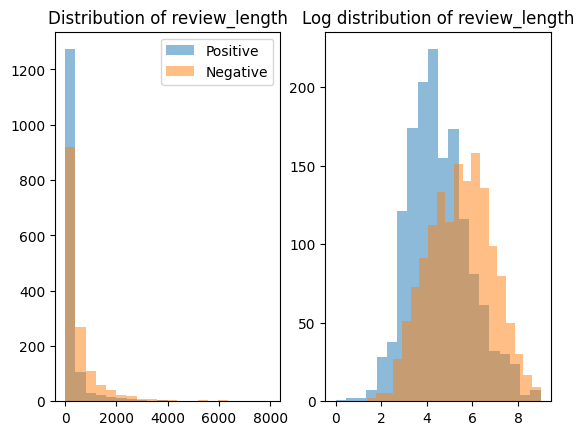

In [180]:
import matplotlib.pyplot as plt

# Calculate the mean lengths of review_text per review_score and print the result.
def len_str(text):
    return len(str(text))

df['review_length'] = df['review_text'].apply(len_str)
mean_review_length = df.groupby('review_score')['review_length'].mean()

print(f'Review mean length:\n{mean_review_length}')

# Calculate the natural log of the lengths since the original plot is very skewed.
# Plot the results.
df['review_length_log'] = df['review_length'].apply(math.log)

positive = df[df['review_score'] == 1]
negative = df[df['review_score'] == -1]

fig, axs = plt.subplots(1, 2)
axs[0].hist(positive['review_length'], alpha=0.5, bins=20, label='Positive')
axs[0].hist(negative['review_length'], alpha=0.5, bins=20, label='Negative')
axs[1].hist(positive['review_length_log'], alpha=0.5, bins=20, label='Positive')
axs[1].hist(negative['review_length_log'], alpha=0.5, bins=20, label='Negative')
axs[0].title.set_text('Distribution of review_length')
axs[1].title.set_text('Log distribution of review_length')
axs[0].legend()
plt.show()

## Part 2: Data cleaning
1. Replace convert and remove characters and string swequences in the reviews which will interfere with the text analysis.
2. Remove stopwords from the text which are common words with no significant meaning in this jobs context.
3. Stemm words in the reviews to reduce them to the same form, i.e. adjustable -> adjust .
4. Recode the review_score to values 1 and 0 for preparation to use it as the target variable in the model.
5. Make word clouds of common words from the cleaned reviews of positive and negative reviews respectively.
Noteworthy words from recommendations are "class" and "hat". Class is a fundamental feature of the game, where you play as one out of several player classes. Hat seems to be some joke, the word is repeated several times in some reviews. Googling it tells us it is an old meme.
Noteworthy words from non recommentaions are "valv", "server", "updat" and "now".......... "fun"

In [181]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Clean the column review_text and create a new column with the result.

import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['review_clean'] = df['review_text'].apply(clean_text)

df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Team Fortress 2,New update XD Pay to play or ♥♥♥♥ off XD,-1,41,3.713572,new update xd pay to play or ♥♥♥♥ off xd
1,Team Fortress 2,♥♥♥♥,-1,4,1.386294,♥♥♥♥
2,Team Fortress 2,If you are a person who loves to brag about th...,-1,447,6.102559,if you are a person who loves to brag about th...
3,Team Fortress 2,"It used to be a fun, casual game, but Valve de...",-1,544,6.298949,it used to be a fun casual game but valve deci...
4,Team Fortress 2,What goes on in a tf2 developer's mind? hl2.ex...,-1,7965,8.982812,what goes on in a developers mind not respon...


In [186]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Remove english stopwords from column 'review_clean' with the function remove_stopwords.

import stopwords

stop_words = stopwords.get_stopwords('english')
more_stopwords = ['play', 'game']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['review_clean'] = df['review_clean'].apply(remove_stopwords)

df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean,review_score_target
0,Team Fortress 2,New update XD Pay to play or ♥♥♥♥ off XD,-1,41,3.713572,new updat xd pay ♥♥♥♥ xd,0
1,Team Fortress 2,♥♥♥♥,-1,4,1.386294,♥♥♥♥,0
2,Team Fortress 2,If you are a person who loves to brag about th...,-1,447,6.102559,person love brag size pen backpack love meme s...,0
3,Team Fortress 2,"It used to be a fun, casual game, but Valve de...",-1,544,6.298949,use fun casual valv decid releas metric ♥♥♥♥to...,0
4,Team Fortress 2,What goes on in a tf2 developer's mind? hl2.ex...,-1,7965,8.982812,goe develop mind respond communiti add weapon ...,0


In [187]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Stemm the words in column 'review_clean' with the function stemm_text

import nltk

stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['review_clean'] = df['review_clean'].apply(stemm_text)

df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean,review_score_target
0,Team Fortress 2,New update XD Pay to play or ♥♥♥♥ off XD,-1,41,3.713572,new updat xd pay ♥♥♥♥ xd,0
1,Team Fortress 2,♥♥♥♥,-1,4,1.386294,♥♥♥♥,0
2,Team Fortress 2,If you are a person who loves to brag about th...,-1,447,6.102559,person love brag size pen backpack love meme s...,0
3,Team Fortress 2,"It used to be a fun, casual game, but Valve de...",-1,544,6.298949,use fun casual valv decid relea metric ♥♥♥♥ton...,0
4,Team Fortress 2,What goes on in a tf2 developer's mind? hl2.ex...,-1,7965,8.982812,goe develop mind respond communiti add weapon ...,0


In [188]:
# Create a column 'review_score_target' with 0 and 1 as values instead of -1 and 1 from 'review_score'.
# Create x and y variables to be used for modeling and double check that their sizes are equal.

def targetEncoded(toEncode):
    return 1 if toEncode == 1 else 0

df['review_score_target'] = df['review_score'].apply(targetEncoded)

x = df['review_clean']
y = df['review_score_target']

print(f'{len(x) = }, {len(y) = }')
df.groupby(['review_score', 'review_score_target']).size()

len(x) = 2966, len(y) = 2966


review_score  review_score_target
-1            0                      1483
 1            1                      1483
dtype: int64

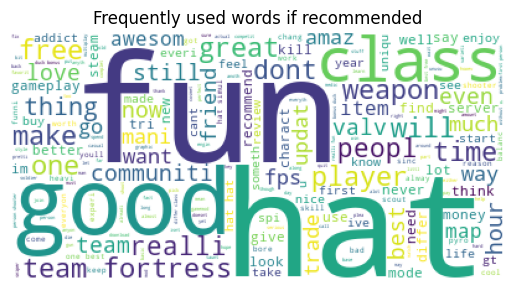

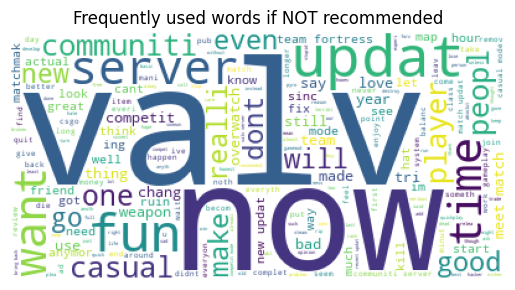

In [190]:
# Make wordclouds for words used in recommended reviews and not recommended reviews.

from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_words=200)

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 1, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if recommended')
plt.imshow(wc)
plt.show()

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 0, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if NOT recommended')
plt.imshow(wc)
plt.show()

## Part 3: Train and evaluate the model and analyze its features
1. Split the data into train and test sets.
2. Create document term matrices of the review data. They are showing the counts of each of the most frequent used words for each review.
3. Create TF-IDF matrices which are similiar to the ones in 2. but shows TD-IDF values instead of counts. Basically they are lower for commonly used words so that they will have a lower impact on the models output. Check the words with the highest and lowest values.
4. Train a Multinomial Naive Bayes model to classify reviews into recommended and not recommended based on the review text.
5. Evaluate the models predicting capabilities.
6. See which words has the highest impact on classifying a review as recommended and not recommended. Its based on the probabilities that they are found in a review of a certain class.
Conclusion is.....
also checked counts in model

In [192]:
# Split the data into train (75%) and test (25%) sets for the x and y variables.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

print(f'{len(x_train) = }, {len(y_train) = }')
print(f'{len(x_test) = }, {len(y_test) = }')

len(x_train) = 2224, len(y_train) = 2224
len(x_test) = 742, len(y_test) = 742


In [193]:
from sklearn.feature_extraction.text import CountVectorizer

# Already filtered through stopwords above, but do it again just in case.
vect = CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=100)

# Create a vocabulary dictionary of the top n most frequent words.
vect.fit(x_train)

# Transform the x sets to document term matrices based on the fitted CountVectorizer.
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

print(f'Example:\n(Review number, word)   Count\n{x_train_dtm[0]}')

Example:
(Review number, word)   Count
  (0, 30)	1
  (0, 42)	1
  (0, 48)	1
  (0, 63)	2
  (0, 91)	1


In [194]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)

# Transform the counts to TF-IDF values. The values are higher for words in shorter reviews and are rarer across the vocabulary.
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

print(f'Example:\n(Review number, word)   TF-IDF\n{x_train_tfidf[0]}')

Example:
(Review number, word)   TF-IDF
  (0, 91)	0.29041309436755186
  (0, 63)	0.7565618454823253
  (0, 48)	0.3477599136473922
  (0, 42)	0.33840680010425395
  (0, 30)	0.328356953152205


In [195]:
# Get mean weights of all the words and print the highest and lowest values.

from sklearn.feature_extraction.text import TfidfVectorizer

# Create the dataframe with the words as column names.
tfidf_array = pd.DataFrame(x_train_tfidf.toarray(), columns = vect.get_feature_names_out())

# Calculate the means of the TF-IDF values but exclude 0. 
# 0 means a review is not using that word, and those should not affect the means.
tfidf_means = [(tfidf_array[tfidf_array[col] > 0][col].mean(), col) for col in tfidf_array]

print(f'Highest means:\n{sorted(tfidf_means, reverse=True)[:5]}')
print(f'\nLowest means:\n{sorted(tfidf_means, reverse=False)[:5]}')

Highest means:
[(0.42100801186210257, 'hat'), (0.4032211342666636, 'best'), (0.39906968935302306, 'ing'), (0.3827687471936976, 'life'), (0.3786309824348672, 'free')]

Lowest means:
[(0.1838325060927558, 'anoth'), (0.1965426780390164, 'someth'), (0.19932368001036152, 'point'), (0.2009013797907735, 'look'), (0.20592937804885966, 'leav')]


In [207]:
# Train the model and make a prediction on the test set.

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model.
nb.fit(x_train_tfidf, y_train)

# Predict the class for each review.
y_pred_class = nb.predict(x_test_dtm)

# Get prediction probabilities for class 1 (review recommends).
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

print(y_pred_class[:4])
print(y_pred_prob[:4])

[1 0 1 1]
[9.88506976e-01 2.22015555e-04 9.09104864e-01 5.07194245e-01]


In [208]:
from sklearn import metrics

# Evaluate the prediction results
print('Model evaluation:\n')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')
print(f'ROC: {metrics.roc_auc_score(y_test, y_pred_prob)}\n')
print(classification_report(y_test, y_pred_class))
print(f'Confusion matrix:\n[[TN  FP]\n [FN  TP]]\n{metrics.confusion_matrix(y_test, y_pred_class)}')

Model evaluation:

Accuracy: 0.8504043126684636
ROC: 0.9076937074644248

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       387
           1       0.84      0.85      0.84       355

    accuracy                           0.85       742
   macro avg       0.85      0.85      0.85       742
weighted avg       0.85      0.85      0.85       742

Confusion matrix:
[[TN  FP]
 [FN  TP]]
[[331  56]
 [ 55 300]]


In [163]:
print('Words with the highest importance of predicting a recommendation:\n(Word Probability)')

for word in sorted(list(zip(nb.feature_log_prob_[1], tfidf_transformer.get_feature_names_out(vect.get_feature_names_out()))), reverse=True)[:7]:
    print(f'{word[1]} {round(np.exp(word[0]), 4)}')

print('\nWords with the highest importance of predicting a non-recommendation:\n(Word Probability)')

for word in sorted(list(zip(nb.feature_log_prob_[0], tfidf_transformer.get_feature_names_out(vect.get_feature_names_out()))), reverse=True)[:7]:
    print(f'{word[1]} {round(np.exp(word[0]), 4)}')


Words with the highest importance of predicting a recommendation:
(Word Probability)
hat 0.0493
fun 0.0399
best 0.039
good 0.0322
free 0.0307
play 0.0259
great 0.0257

Words with the highest importance of predicting a non-recommendation:
(Word Probability)
updat 0.0494
valv 0.0375
match 0.0239
server 0.0232
just 0.0231
new 0.0231
casual 0.022


In [162]:
FP = x_test[(y_pred_class == 1) & (y_test == 0)]
FN = x_test[(y_pred_class == 0) & (y_test == 1)]